# Structured data classification I

*This tutorial is mainly based on the Keras tutorial ["Structured data classification from scratch"](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/) by François Chollet.*

- This example demonstrates how to do structured binary classification with Keras, starting from a raw CSV file. 

- Our data includes both numerical and categorical features. 

- We will use Keras preprocessing layers to normalize the numerical features and vectorize the categorical ones.

```{Note}
Note that this example should be run with TensorFlow 2.5 or higher.
```

## Setup

In [24]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

tf.__version__

'2.7.1'

## Data

- [Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the Cleveland Clinic Foundation for Heart Disease.

- It's a CSV file with 303 rows. Each row contains information about a patient (a**sample**), and each column describes an attribute of the patient (a **feature**). 

- We use the features to predict whether a patient has a heart disease (**binary classification**).


Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | normal; fixed defect; reversible defect | Categorical (string)
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

The following feature are continuous numerical features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

The following features are *categorical features* encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

The following feature is a *categorical features* encoded as string:

- `thal`



### Data import
Let's download the data and load it into a Pandas dataframe:

In [25]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

- Here's a preview of a few samples:

In [26]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


- The dataset includes 303 samples with 14 columns per sample (13 features, plus the target label).

- The last column, "target", indicates whether the patient has a heart disease (1) or not (0).

### Data splitting

- Let's split the data into a training and validation set:

In [28]:
df_val = df.sample(frac=0.2, random_state=1337)

df_train = df.drop(df_val.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(df_train), len(df_val))
)

Using 242 samples for training and 61 for validation


### Transform to Tensors


- The [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) supports writing descriptive and efficient input pipelines. 

- Dataset usage follows a common pattern:

  - Create a source dataset from your input data.
  - Apply dataset transformations to preprocess the data.
  - Iterate over the dataset and process the elements.

#### Examples

- First, a simple example of how to transform an array into tensors


In [29]:
example_dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])

# Print tensor
for element in example_dataset:
  print(element)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


- Example with a dictionary

In [30]:
example_dataset = tf.data.Dataset.from_tensor_slices({"a":[1, 2], "b":[10, 11]} )

# Print tensor
for element in example_dataset:
  print(element)

{'a': <tf.Tensor: shape=(), dtype=int32, numpy=1>, 'b': <tf.Tensor: shape=(), dtype=int32, numpy=10>}
{'a': <tf.Tensor: shape=(), dtype=int32, numpy=2>, 'b': <tf.Tensor: shape=(), dtype=int32, numpy=11>}


- How to use dictionary in combination with pandas dataframe 


In [31]:
# We only use 1 patient
example_dataset = tf.data.Dataset.from_tensor_slices(dict(df[0:1]))

for element in example_dataset:
  print(element)

{'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'fixed'>, 'target': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


#### Transformation function

- Let's generate [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects for our training and validation dataframes.

- The following utility function converts each training and validation set into a tf.data.Dataset, then shuffles and batches the data.

In [32]:
# Define a function to create our tensors
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=32):
    
    # Make a copy of our dataframe
    df = dataframe.copy()
    # Obtain label and drop target from dataframe
    labels = df.pop("target")

    # Transform data to tensor dataset
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    # Shuffle data
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    
    # Create batches 
    ds = ds.batch(batch_size)
    # Prefetch data for computational efficiency
    df = ds.prefetch(batch_size)

    return ds

- Next, we test our function

- We use a small batch size to keep the output readable

In [33]:
batch_size = 5

ds_train_test = dataframe_to_dataset(df_train, shuffle=True, batch_size=batch_size)

- Let's take a look at the data:

In [34]:
[(train_features, label_batch)] = ds_train_test.take(1)

print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of targets:', label_batch )

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([55 66 34 58 54], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)


- As the output demonstrates, the training set returns a dictionary of column names (from the DataFrame) that map to column values from rows.

#### Use transformation function

- Let's now create a input pipeline with a batch size of 32:

In [35]:
# Use function
batch_size = 32

ds_train = dataframe_to_dataset(df_train, shuffle=True, batch_size=batch_size)
ds_val = dataframe_to_dataset(df_val, shuffle=True, batch_size=batch_size)

## Feature preprocessing

- Next, we perform feature preprocessing with Keras layers. 

### Categorical features


- Remember that the following features are *categorical features* encoded as integers:

  - `sex`
  - `cp`
  - `fbs`
  - `restecg`
  - `exang`
  - `ca`

- First, we need to decide how to represent the categorical data

Option 1: **One-hot encoding**

- Example: a color feature gets a 1 in a specific index for different colors ('red' = [0, 0, 1, 0, 0])

Option 2: **Embed the feature** 

   - Example: each color maps to a unique trainable vector ('red' = [0.1, 0.2, 0.5, -0.2]

```{Note}
As a rule of thumb: Larger category spaces might do better with an embedding;
smaller spaces can use one-hot encoding  
```


- We will encode these features using **one-hot encoding**. We have two options
here:

  - Use [`CategoryEncoding()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CategoryEncoding), which requires knowing the range of input values
 and will error on input outside the range.
 
  - Use [`IntegerLookup()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup) which will build a lookup table for inputs and reserve
 an output index for unkown input values.

- For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.


- We also have a categorical feature encoded as a *string*: `thal`. 

- We will create an index of all possible features and encode output using the `StringLookup()` layer.


### Numeric features

- The following feature are *numerical* features:

  - `age`
  - `trestbps`
  - `chol`
  - `thalach`
  - `oldpeak`
  - `slope`

- For each of these features, we will use a [`Normalization()`](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/) layer to make sure the mean of each feature is 0 and its standard deviation is 1.

### Numerical preprocessing functions


- Below, we define a utility function to do the feature preprocessing operations

- We create the function `encode_numerical_feature` to apply featurewise normalization to numerical features.

In [36]:
# Define numerical preprocessing function
def encode_numerical_feature(feature, name, dataset):

    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    
    return encoded_feature

- We use [tf.expand_dims(input, axis, name=None)](https://www.tensorflow.org/api_docs/python/tf/expand_dims) to return a tensor with a length 1 axis inserted at index axis `-1`. 

- A negative axis counts from the end so `axis=-1` adds an inner most dimension.


### Categorical preprocessing functions

- In our function, we handle two types of categorical data:

  - if the data type is a `string`: turn string inputs into integer indices, then one-hot encode these integer indices.

  - if the data type is an `integer`: one-hot encode integer categorical features.

- During [adapt()](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/), the layer will analyze a data set, determine the frequency of individual strings tokens, and create a vocabulary from them. 

In [37]:
# Define categorical preprocessing function
def encode_categorical_feature(feature, name, dataset, is_string):

    # Use StringLookup for datatype string; otherwise use IntegerLookup
    lookup_class = layers.StringLookup if is_string else layers.IntegerLookup
    
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    
    return encoded_feature


- With this done, we can create our preprocessing steps.

### Data preprocessing

- In this notebook, we don't use functions to perform our data preprocessing

- Instead, we take care of every feature indivdually 


- First, we define `keras.Input` for every feature: 

In [38]:
# Categorical features encoded as integers
sex = tf.keras.Input(shape=(1,), name="sex", dtype="int64")
cp = tf.keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = tf.keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = tf.keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = tf.keras.Input(shape=(1,), name="exang", dtype="int64")
ca = tf.keras.Input(shape=(1,), name="ca", dtype="int64")

In [39]:
# Categorical feature encoded as string
thal = tf.keras.Input(shape=(1,), name="thal", dtype="string")

In [40]:
# Numerical features
age = tf.keras.Input(shape=(1,), name="age")
trestbps = tf.keras.Input(shape=(1,), name="trestbps")
chol = tf.keras.Input(shape=(1,), name="chol")
thalach = tf.keras.Input(shape=(1,), name="thalach")
oldpeak = tf.keras.Input(shape=(1,), name="oldpeak")
slope = tf.keras.Input(shape=(1,), name="slope")

- Perform preprocessing with our functions:

In [42]:
# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", ds_train, False)
cp_encoded = encode_categorical_feature(cp, "cp", ds_train, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", ds_train, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", ds_train, False)
exang_encoded = encode_categorical_feature(exang, "exang", ds_train, False)
ca_encoded = encode_categorical_feature(ca, "ca", ds_train, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", ds_train, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", ds_train)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", ds_train)
chol_encoded = encode_numerical_feature(chol, "chol", ds_train)
thalach_encoded = encode_numerical_feature(thalach, "thalach", ds_train)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", ds_train)
slope_encoded = encode_numerical_feature(slope, "slope", ds_train)

- Merge the list of encoded feature inputs (`encoded_features`) into one vector via concatenation with `layers.concatenate`:

In [43]:
all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
        slope_encoded,
    ]
)

- Make a list of all keras.Input feature names

In [44]:
all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

## Model

- Now we can build the model using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional): 

  1. We use 32 number of units in the first layer
  
  1. We use [layers.Dropout()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) to prevent overvitting
  
  1. Our output layer has 1 output (since the classification task is binary)
  
  1. tf.keras.Model groups layers into an object with training and inference features.

In [46]:
# First layer
x = layers.Dense(32, activation="relu")(all_features)

# Dropout to prevent overvitting
x = layers.Dropout(0.5)(x)

# Output layer
output = layers.Dense(1, activation="sigmoid")(x)

# Group all layers 
model = tf.keras.Model(all_inputs, output)


[Model.compile](https://keras.io/api/models/model_training_apis/) configures the model for training:

- [Optimizer](https://keras.io/api/optimizers/): The mechanism through which the model will update itself based on the training data it sees, so as to improve its performance. One common option for the optimizer is [Adam](https://keras.io/api/optimizers/adam/), a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

- [loss](https://keras.io/api/losses/): How the model will be able to measure its performance on the training data, and thus how it will be able to steer itself in the right direction. This means the purpose of loss functions is to compute the quantity that a model should seek to minimize during training. 

- [metrics](https://keras.io/api/metrics/): A metric is a function that is used to judge the performance of your model during training and testing. Here, we’ll only care about accuracy.


In [47]:
model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

- Let's visualize our connectivity graph:

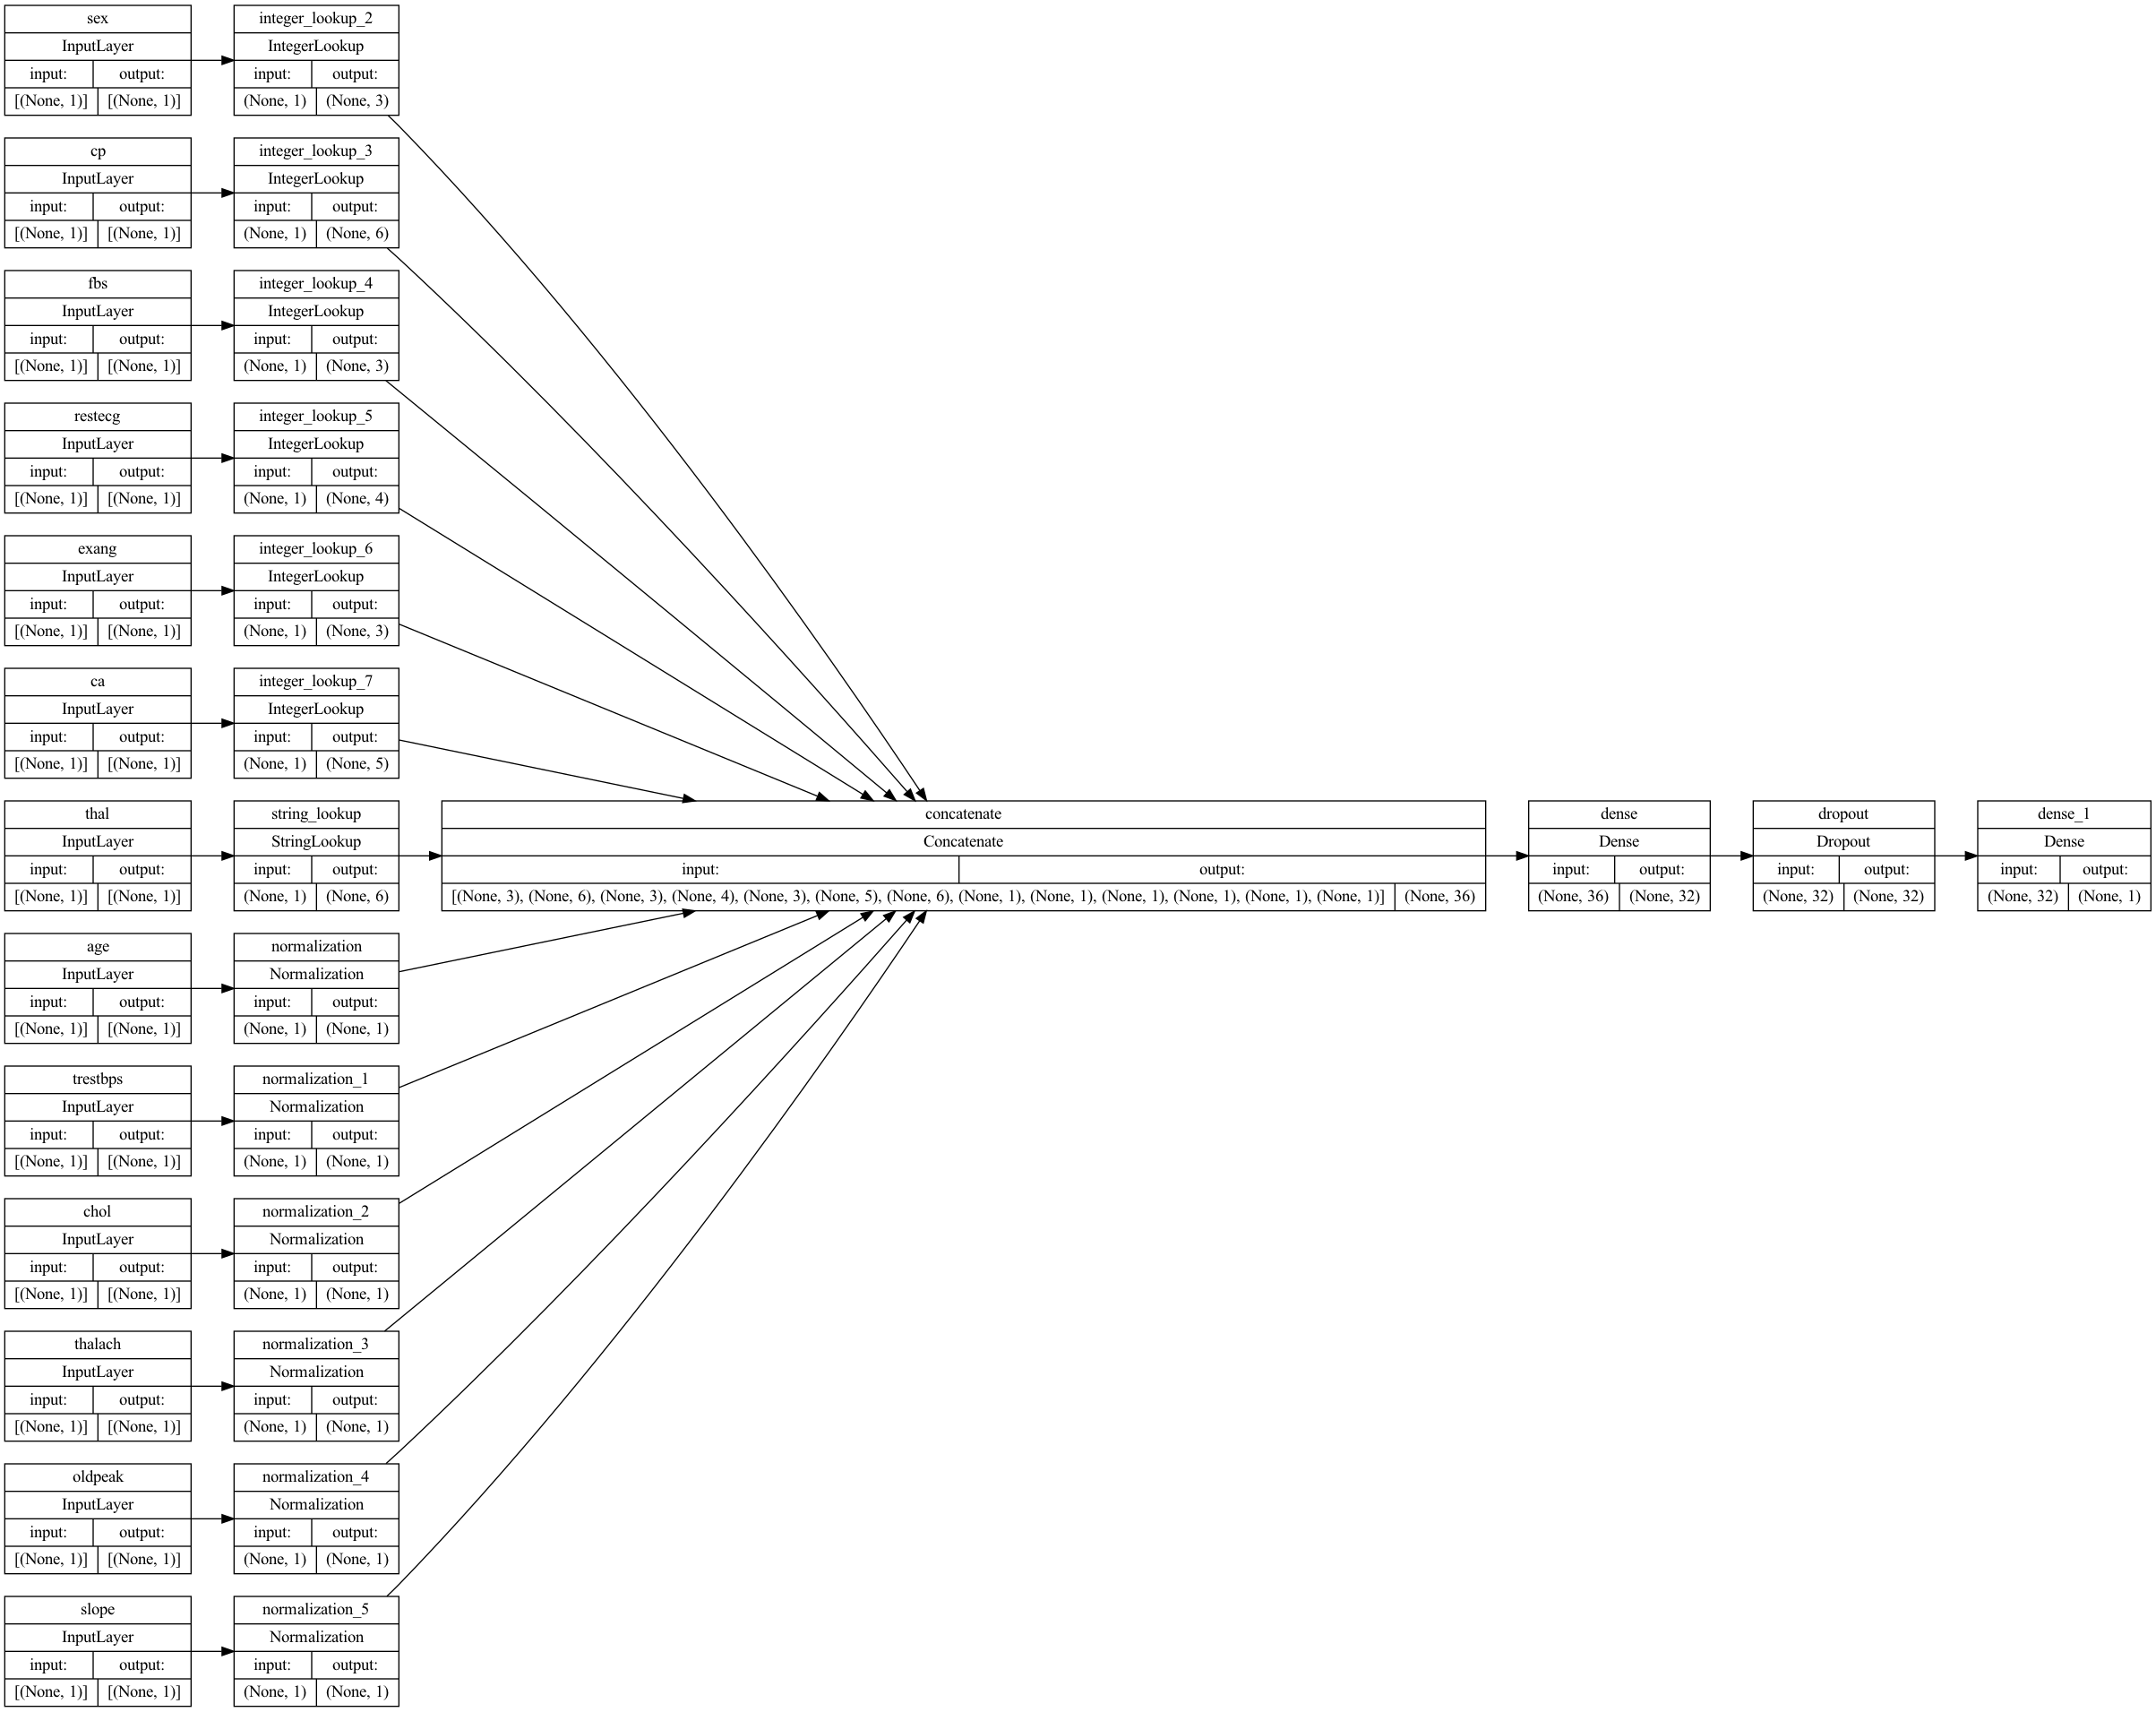

In [48]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Training

- Next, we train the model for a fixed number of epochs (iterations on a dataset).

- An epoch is an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation. 

- Here, we only use 10 epochs.

In [49]:
model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
8/8 [==============================] - 1s 32ms/step - loss: 0.4971 - accuracy: 0.7521 - val_loss: 0.4810 - val_accuracy: 0.7377
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4806 - accuracy: 0.7645 - val_loss: 0.4564 - val_accuracy: 0.7705
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4821 - accuracy: 0.7521 - val_loss: 0.4365 - val_accuracy: 0.7705
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.7934 - val_loss: 0.4214 - val_accuracy: 0.7705
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4363 - accuracy: 0.7934 - val_loss: 0.4097 - val_accuracy: 0.7869
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4306 - accuracy: 0.7686 - val_loss: 0.4014 - val_accuracy: 0.7869
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4020 - accuracy: 0.8264 - val_loss: 0.3956 - val_accuracy: 0.8033
Epoch 8/10
8/8 [=================

- We quickly get to around 80% validation accuracy.

In [52]:
loss, accuracy = model.evaluate(ds_val, verbose=0)

print("Accuracy", round(accuracy, 2))

Accuracy 0.82


## Perform inference

- To get a prediction for a new sample, you can simply call `model.predict()`. 

- There are just two things you need to do:

  1. wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)

  2. Call `convert_to_tensor` on each feature

In [53]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

In [54]:
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

In [55]:
predictions = model.predict(input_dict)

In [56]:
print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 39.6 percent probability of having a heart disease, as evaluated by our model.


## Next steps

- In this example, we used a lot of code to demonstrate the data preprocessing as simple as possible.

- If you want to learn more about how to reduce this code by using functions, take a look at the following example which uses the same data and model: [](structured_data_classification_functions.ipynb)